# FDEM Part 2

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines a surface to borehole logging example similar to that discussed in [Augustin et al. (1989)](https://doi.org/10.1190/1.1442581). This notebook was used to produce Figures 11 and 12  in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python pachages
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

# SimPEG and discretize packages
import discretize
from discretize import utils
from SimPEG.EM import FDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

# utilities for running casing simulations
import casingSimulations as casingSim

%matplotlib inline

## Simulation Setup

In [3]:
simDir = 'FDEM_Augustin'  # create a simulation directory where results can be saved. 

We will two classes of examples
- permeable wells, one example is run for each $\mu_r$ in `casing_mur`. The conductivity of this well is `sigma_permeable_casing`
- conductive wells ($\mu_r$=1), one example is run for each $\sigma$ value in `sigma_casing`

In [4]:
casing_mur = [100]  # the casing permeabilities to model
sigma_casing = [1e6, 1e8]  # conductivie
sigma_permeable_casing = 1e6

In [5]:
sigma_air = 1e-4
sigma_back = 1e-4
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter
casing_l = 2000

def get_model(mur, sig):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sig,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

Here, we create a dictionary to keep track of our models

In [6]:
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]
model_names_conductive = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

In [7]:
# conductive, permeable models
model_dict_permeable = {
    key: get_model(mur, sigma_permeable_casing) for key, mur in zip(model_names_permeable, casing_mur)
}

model_dict_conductive = {
    key: get_model(1, sig) for key, sig in zip(model_names_conductive, sigma_casing)
}

model_names = model_names_conductive + model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)
model_dict.update(model_dict_conductive)

In [8]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_1e+06', 'casing_1e+08', 'casing_100']

## Frequencies and Mesh

Now that the model parameters have been defined, we set up the survey frequencies and define a mesh. We will run simulations for 60 frequencies between 0.01Hz and 10$^4$ Hz

In [9]:
freqs = np.logspace(-2, 4, 60)
for mod in model_dict.values():
    mod.freqs = freqs

In [10]:
# parameters defining the core region of the mesh
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 20, 27  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

Skin depth: 5.0e+05 m


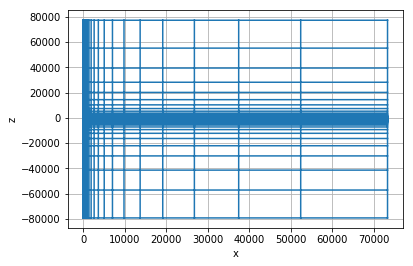

In [11]:
mesh_generator = get_mesh(model_dict[model_names[0]])
print(
    "Skin depth: {:1.1e} m".format(
        model_dict[model_names[0]].skin_depth().max())
)
mesh_generator.mesh.plotGrid()

## Physical properties

Having defined the mesh and the model parameters, we can now populate out simulation domiain with physical properties.

In [12]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.items()
}

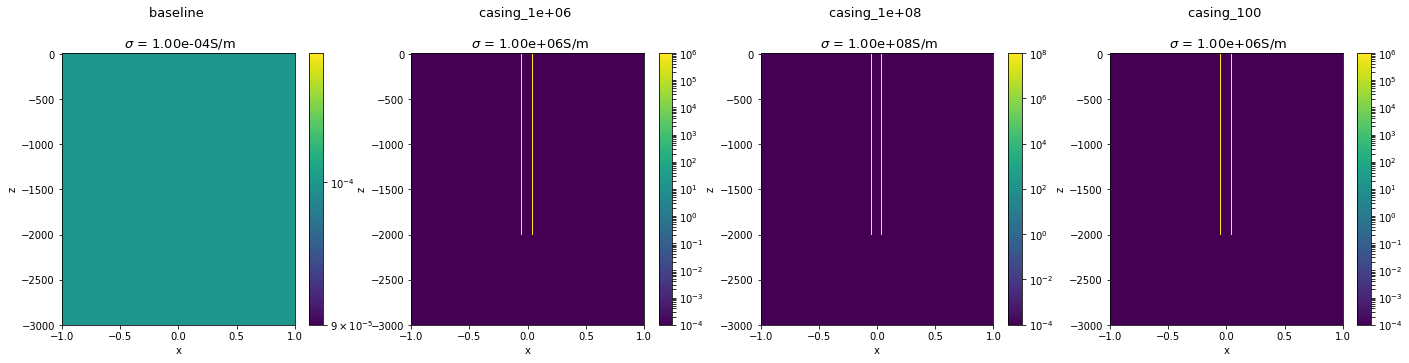

In [13]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

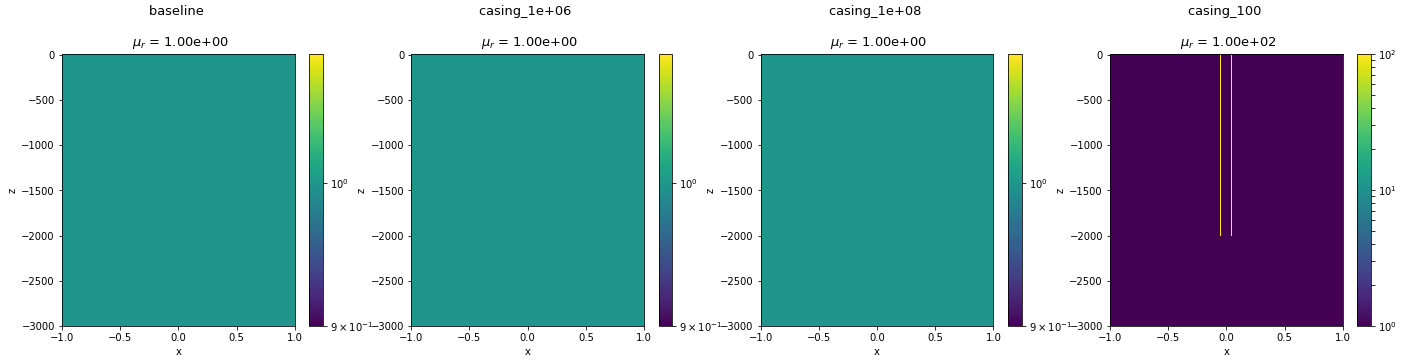

In [14]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_mur(ax=a, pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Survey

We use a large loop source (100m radius) and a single b-field reciever that is inside the well, 500m below the surface of the earth. 

In [15]:
rx_loc = np.array([[0., 0., -500.]])

In [16]:
rx_re = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="real")
rx_im = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="imag")

In [17]:
loop_radius = 100
src_list = [FDEM.Src.CircularLoop(
    [rx_re, rx_im], f, np.r_[0., 0., 0.], orientation="z", moment=1, radius=100
) for f in freqs]

## Set up the Simulation

In [18]:
wires = physpropsDict[model_names[0]].wires  # keeps track of which model parameters are sigma and which are mu
prob = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu, Solver=Pardiso)

In [19]:
survey = FDEM.Survey(src_list)
prob.pair(survey)

## Run the simulation

In [20]:
fields_dict = {}

In [21]:
def run_simulation(key):
    if key not in fields_dict.keys():
        t = time.time()
        print('--- Running {} ---'.format(key))
        fields_dict[key] = prob.fields(physpropsDict[key].model)
        print(" ... done. Elapsed time {}\n".format(time.time() - t))

In [22]:
%%time
for key in model_names:
    run_simulation(key)

--- Running baseline ---
 ... done. Elapsed time 27.3666579723

--- Running casing_1e+06 ---
 ... done. Elapsed time 25.9871909618

--- Running casing_1e+08 ---
 ... done. Elapsed time 27.1241979599

--- Running casing_100 ---
 ... done. Elapsed time 37.7980718613

CPU times: user 3min 6s, sys: 22.4 s, total: 3min 29s
Wall time: 1min 58s


compute data from the fields

In [23]:
data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    prob.model = model
    data_dict[key] = survey.dpred(model, f=fields_dict[key])

## Plot the normalized secondary field

In [24]:
def plot_nsf(ax=None, subtract=None, models=None, colors=None):
    """
    Plot the normalized secondary field at the reciever location.
    The normalized secondary field is the ratio of the secondary 
    field (with respect to a free-space primary) and the primary
    """
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, dpi=400)
    
    if colors is None:
        colors = ["C{}".format(i if i < 10 else i - 10) for i in range(len(models))]
    plot_models = model_names[1:]
    if models is not None:
        if type(models) == str:
            if models.lower() == "permeable":
                plot_models = model_names_permeable
            elif models.lower() == "conductive":
                plot_models = model_names_conductive
        else:
            plot_models = models
        
            
        
    for i, key in enumerate(plot_models):
        bPrimary = rx_re.getP(mesh_generator.mesh) * src_list[i].bPrimary(prob)
        data = (data_dict[key]).copy()
        prob.model = physpropsDict[key].model
        data_re = data[0::2] / bPrimary
        data_im = data[1::2] / bPrimary
        
        if subtract is not None:
            if subtract.lower() == "conductive":
                data_re -= data_dict["casing_1"][0::2] / bPrimary 
                data_im -= data_dict["casing_1"][1::2] / bPrimary
        
        label = "$\sigma$ = {:1.0e}, $\mu_r$ = {:1.0f}".format(
            model_dict[key].sigma_casing, model_dict[key].mur_casing 
        )
        ax.semilogx(freqs, data_re, color=colors[i], label=label)
        ax.semilogx(freqs, data_im, color=colors[i], linestyle="--")
        
    ax.legend(fontsize=8)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("NSF")
    ax.grid(which='both', alpha=0.4)
    # ax.set_ylabel()
#     plt.show()

In [25]:
from matplotlib import rcParams
rcParams['font.size'] = 10

## Figure 11

Text(1200,-0.98,u'real part')

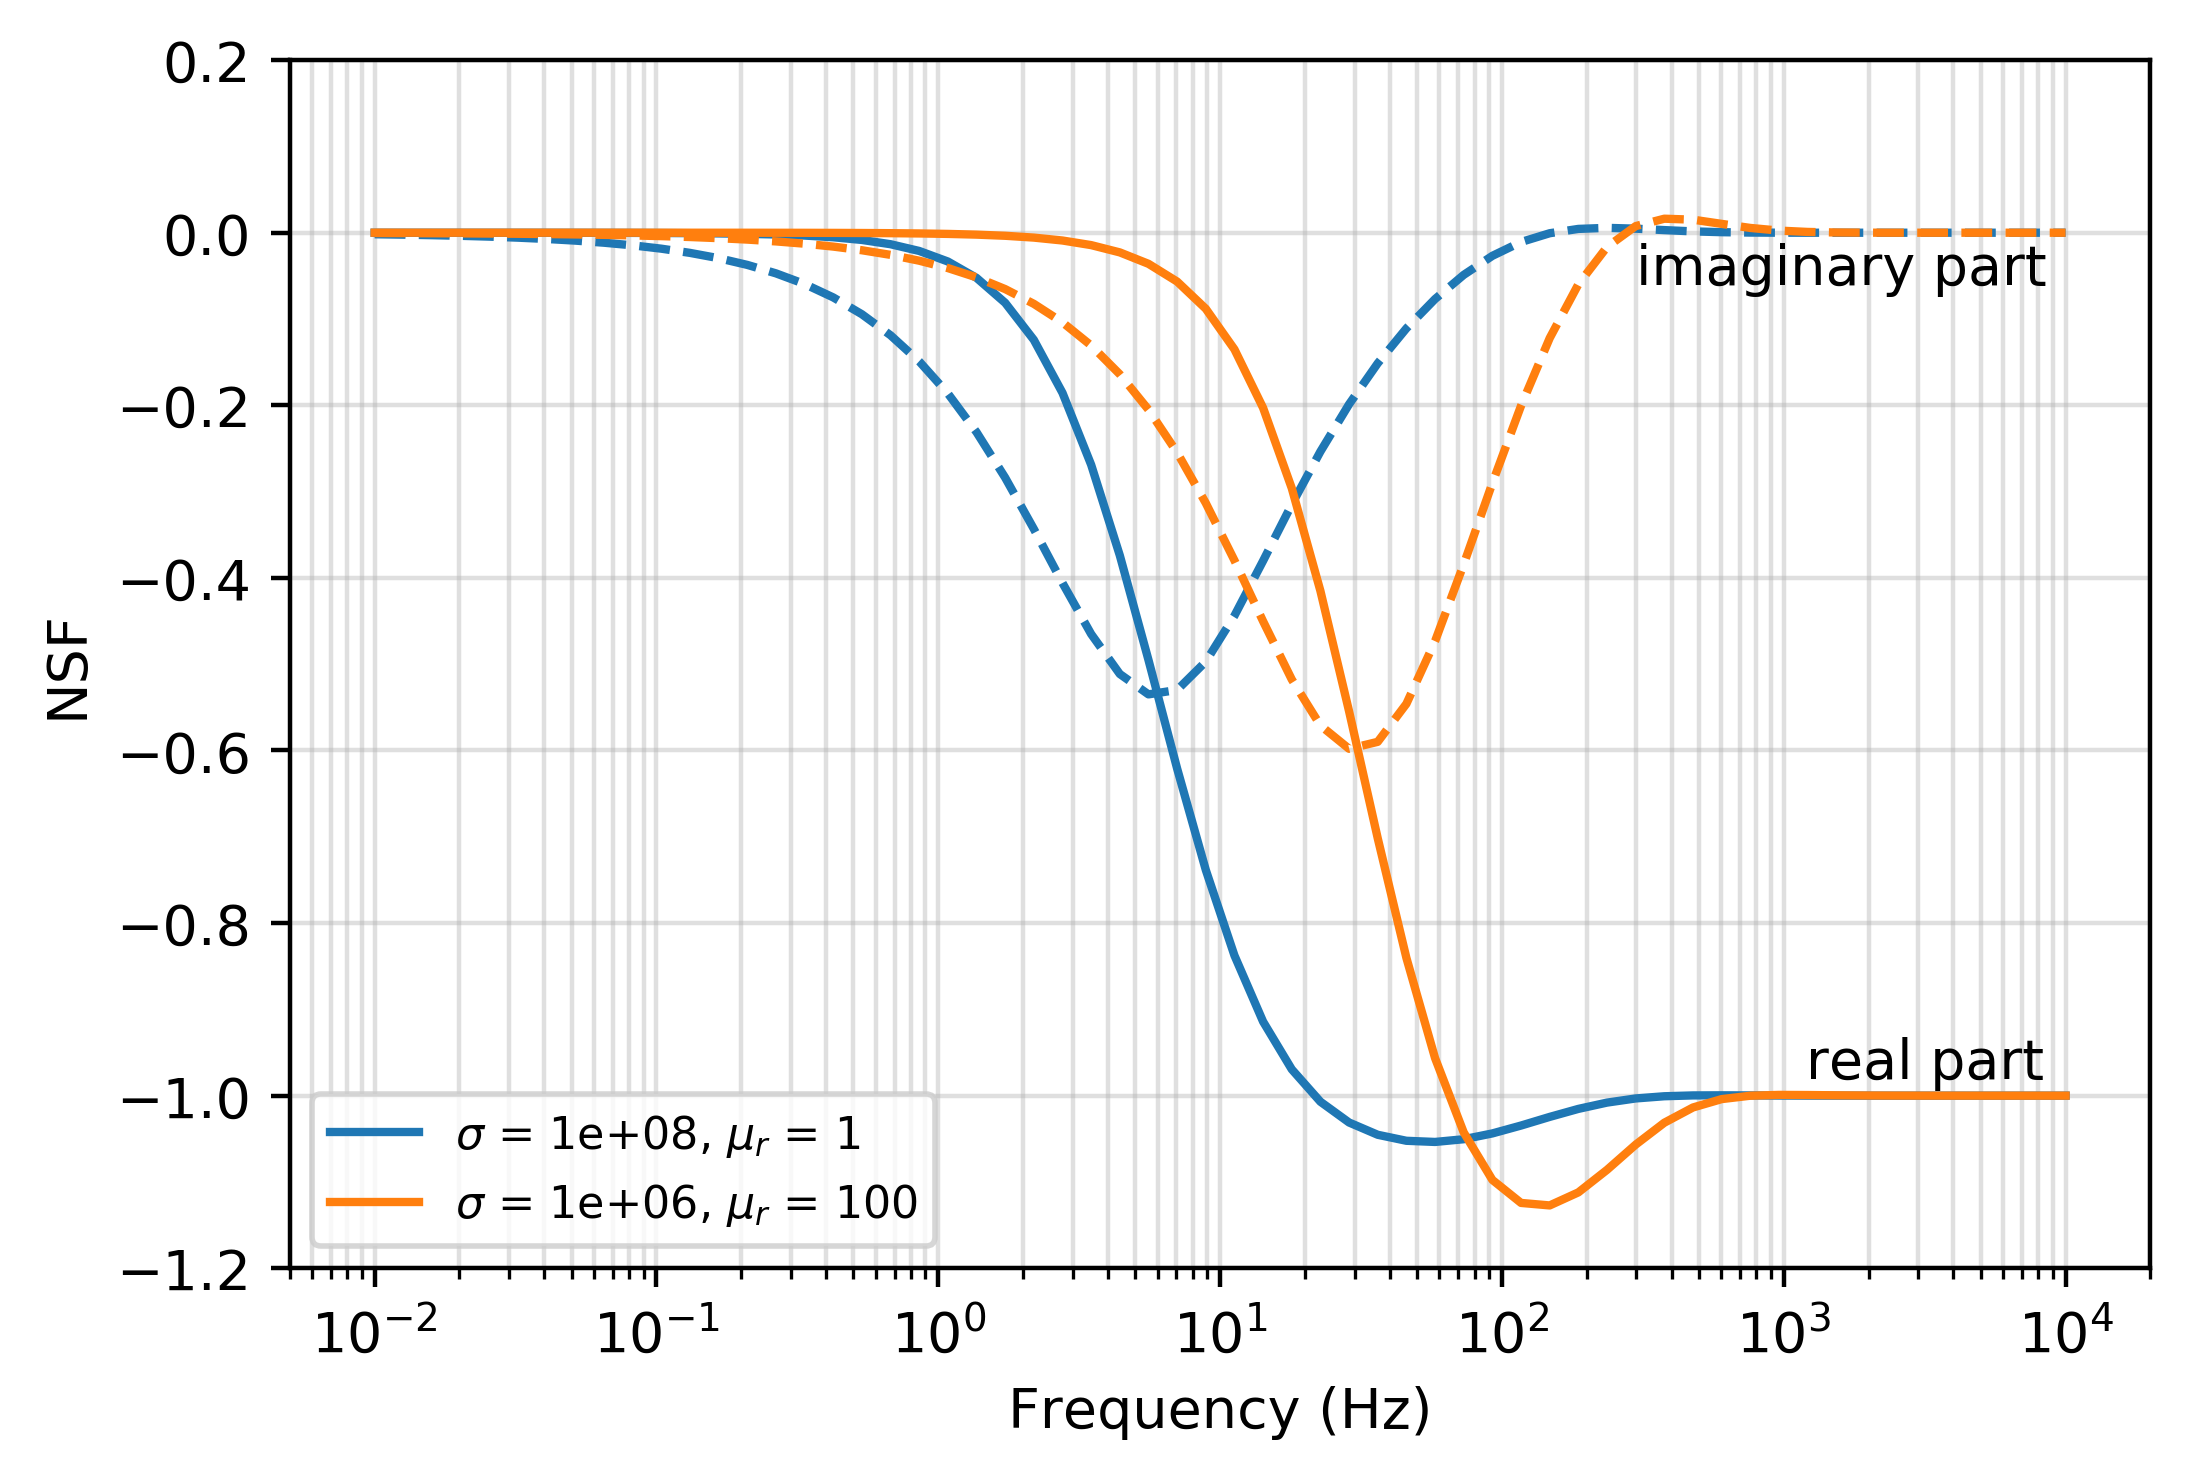

In [26]:
fig, ax = plt.subplots(1, 1, dpi=400)
plot_nsf(ax=ax, models=["casing_1e+08", "casing_100"], colors = ["C0", "C1"])

ax.set_ylim([-1.2, 0.2])
ax.text(3e2, -0.06, 'imaginary part')
ax.text(1.2e3, -0.98, 'real part')

# fig.savefig('fdemNSF')

In [27]:
sim_dict = {}
for key in model_names:
    sim = casingSim.run.SimulationFDEM(
        directory=simDir, 
        meshGenerator=mesh_generator,
        modelParameters=model_dict[key],
        formulation=prob._solutionType[0],
    )
    sim._prob = prob
    sim._survey = survey
    sim_dict[key] = sim

## View the fields and fluxes

This is a widget for interrogating the results. 
- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: `primary` plots the background, `secondary` subtracts the `primary` response from the current value (note that if you select `background` and `secondary` the value will be zero and an error thrown
- `real_or_imag`: plot the real or imaginary component
- `src_ind`: index of the source frequency that we are plotting
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `use_aspect`: if checked, the aspect ratio of the axes is set to 1 (eg. no vertical or horizontal exxageration) 
- `casing_outline`: draws the outline of the casing

In [28]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key='baseline'
)

In [29]:
viewer.widget_cross_section()

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

## Figure 12 

We now choose 5 frequencies to make the plot showing the magnetic flux

In [30]:
from matplotlib import rcParams
rcParams['font.size'] = 16

In [31]:
freqs2 = [0.1, 1, 10, 100, 1000]
src_list2 = [FDEM.Src.CircularLoop(
    [rx_re, rx_im], f, np.r_[0., 0., 0.], orientation="z", moment=1, radius=100
) for f in freqs2]
prob2 = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu, Solver=Pardiso)
survey2 = FDEM.Survey(src_list2)
prob2.pair(survey2)

In [32]:
fields_dict2 = {}

In [33]:
def run_simulation2(key):
    if key not in fields_dict2.keys():
        t = time.time()
        print('--- Running {} ---'.format(key))
        fields_dict2[key] = prob2.fields(physpropsDict[key].model)
        print(" ... done. Elapsed time {}\n".format(time.time() - t))

In [34]:
%%time
for key in model_names:
    run_simulation2(key)

--- Running baseline ---
 ... done. Elapsed time 3.15592813492

--- Running casing_1e+06 ---
 ... done. Elapsed time 3.22519207001

--- Running casing_1e+08 ---
 ... done. Elapsed time 3.30071401596

--- Running casing_100 ---
 ... done. Elapsed time 3.55110001564

CPU times: user 19.4 s, sys: 2.47 s, total: 21.9 s
Wall time: 13.2 s


In [35]:
sim_dict2 = {}
for key in model_names:
    sim = casingSim.run.SimulationFDEM(
        directory=simDir, 
        meshGenerator=mesh_generator,
        modelParameters=model_dict[key],
        formulation=prob2._solutionType[0],
    )
    sim._prob = prob2
    sim._survey = survey2
    sim_dict2[key] = sim

In [36]:
viewer2 = casingSim.FieldsViewer(
    sim_dict=sim_dict2 , fields_dict=fields_dict2, model_keys=model_names, primary_key='baseline'
)

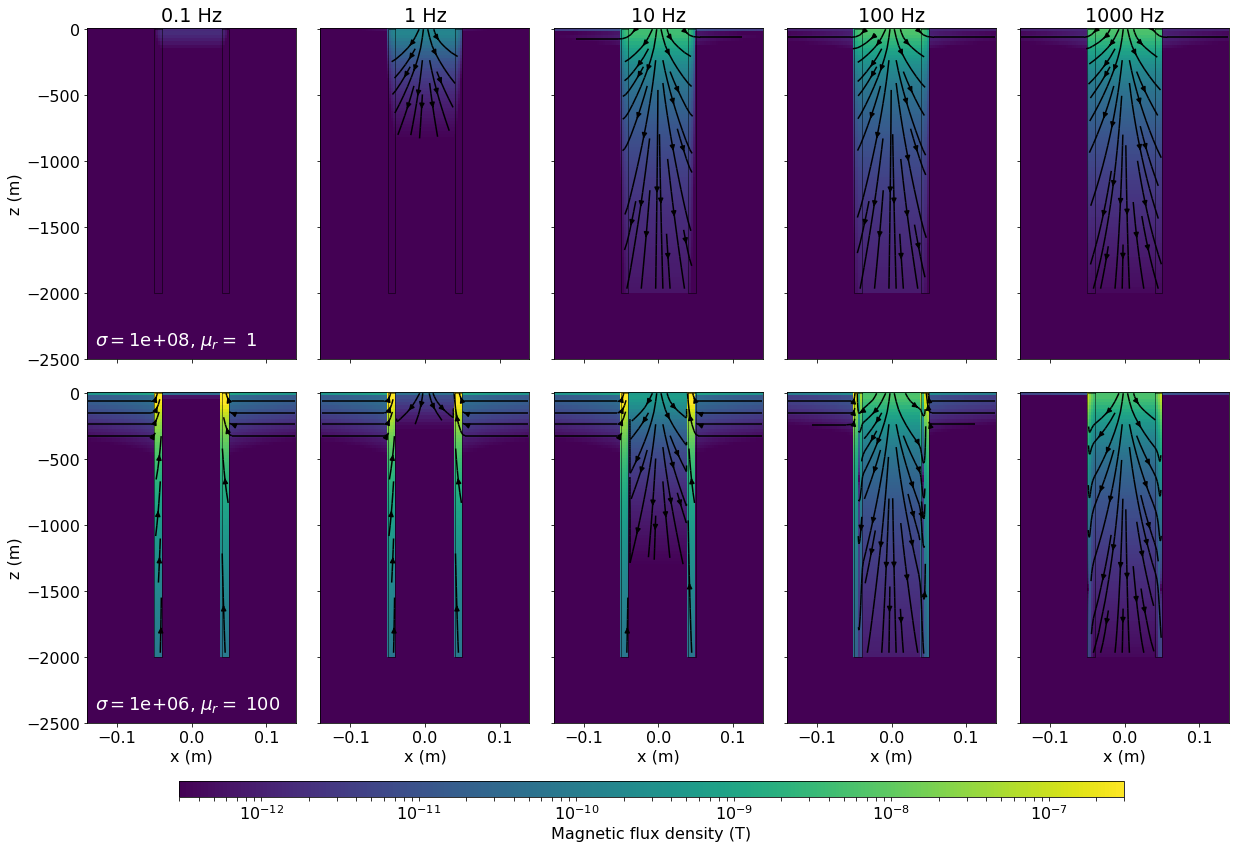

In [37]:
fig, ax = plt.subplots(2, 5, figsize=(3.5*5, 5.5*2))
fig.subplots_adjust(bottom=0.8)

clim = [3e-13, 3e-7]
max_depth = 2500
top = 10
max_r = 0.14
view='b'
primsec="secondary"
component="real"

for i, f in enumerate(freqs2):
    for j, m in enumerate(["casing_1e+08", "casing_100"]):
        a = ax[j, i]
        out = viewer2.plot_cross_section(
            ax=a, clim=clim, zlim=np.r_[-max_depth, top], 
            xlim=max_r*np.r_[-1., 1.], view=view, model_key=m, 
            prim_sec=primsec, 
            casing_outline=True,
            real_or_imag=component,
            src_ind=i, 
            show_cb=False
        )
        
        
        if j == 0:
            a.set_title("{} Hz".format(f))
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            
            
        else:
            a.set_title("")
            a.set_xlabel("x (m)")
    
        if i > 0:
            a.set_yticklabels(['']*len(a.get_yticklabels()))
            a.set_ylabel('')
        else:
            a.set_ylabel('z (m)')
            mod = model_dict[m]
            a.text(
                -0.13, -2400, "$\sigma = ${:1.0e}, $\mu_r = $ {:1.0f}".format(mod.sigma_casing, mod.mur_casing), 
                color="w", fontsize=18
            )


plt.tight_layout()


cbar_ax = fig.add_axes([0.15, -0.02, 0.75, 0.02])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic flux density (T)')


In [38]:
# fig.savefig('bfedm', dpi=300, bbox_inches="tight")